<a href="https://colab.research.google.com/github/gmazzitelli/GSN2/blob/master/IFNFCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

## setup generale
</div>
load funzioni e dati

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":11,"axes.titlesize":16,"axes.labelsize":11})
c = ['tab:blue','tab:red', 'tab:gray','tab:orange','tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

def Exp(x, p0, p1): # negative exponential
  import numpy as np
  return p0*np.exp(x/p1)

def Line(x, m, q):
  import numpy as np
  return m*x + q

def Gain(x, p0, p1):
  import numpy as np
  return p0*x**p1

def panda_from_gspreadsheet(key, sheet_name='Sheet1', header=0):
  # google spredsheet TO panda dataframe
  # ricordarsi di abilitare lo sharing pubblico dei dati

  url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
      key=key, sheet_name=sheet_name.replace(' ', '%20'))
  return pd.read_csv(url, header=header)

# df =  panda_from_gspreadsheet('1MWRb1xbkpZOmUBLCLaC9ud4htvPEWYC7F8IuTt84YBg', sheet_name='Sheet1')
df =  panda_from_gspreadsheet('1bPAhcjzy2BQFaGO2-I3_XsZSpZ0060jcwqIyuPkxR2w', sheet_name='Sheet1')

CSN = pd.unique(df['Scientific Committee'])
pledges = ["CPU - total amount (I)", "Storage - size (I)", "Tape - size (I)"]
experiments = df["Experiment or project/initiative"].values

for i, pledge in enumerate(pledges):
  if pledge == "CPU - total amount (I)":
    df.loc[df[pledge].isnull(), pledge]='No CPU Pledge'
  elif pledge == "Storage - size (I)":
    df.loc[df[pledge].isnull(), pledge]='No Disk Storage Pledge'
  elif pledge == "Tape - size (I)":
    df.loc[df[pledge].isnull(), pledge]='No Tape Pledge'
  else:
    print ("Error no change")
df.tail(1)


,Timestamp,Email Address,Experiment or project/initiative,Unnamed: 3,Computing model evolution,Real Data amount,Real Data size,Data structure,Metadata/calibrations/slow-control,Production sites,...,CPU - total amount (III),CPU - total amount (II),Storage - size (III),Storage - size (II),Tape - size (III),Tape - size (II),Score,Additional comments/specifications,Storage - size,Storage - size.1
69,11/4/2023 17:02:41,leonardo.carminati@mi.infn.it,ATLAS,NaN,Currently defined and stable,>100M,1MB-10MB,For data :\nRaw->AOD->DAOD_PHYS/PHYSLITE ( + e...,"Metadata, Calibration data, Slow-control info",Data are processed at T0 and distributed to gr...,...,>1000,10-30%,>10PB,30-60%,>10PB,30-60%,NaN,NaN,NaN,NaN


<div class="markdown-google-sans">

## partecipazione
</div>

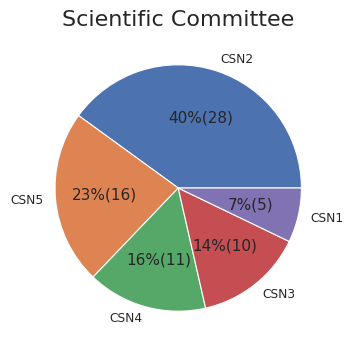

In [8]:
fig, ax = plt.subplots(figsize=(4,4))
what = "Scientific Committee"
elements = len(df[what])
pd.value_counts(df[what]).plot(kind='pie', autopct=lambda x: '{:.0f}%({:.0f})'.format(x, x*elements/100), label="")
plt.title(what)
plt.show()

<div class="markdown-google-sans">

## Computing model evolution
</div>



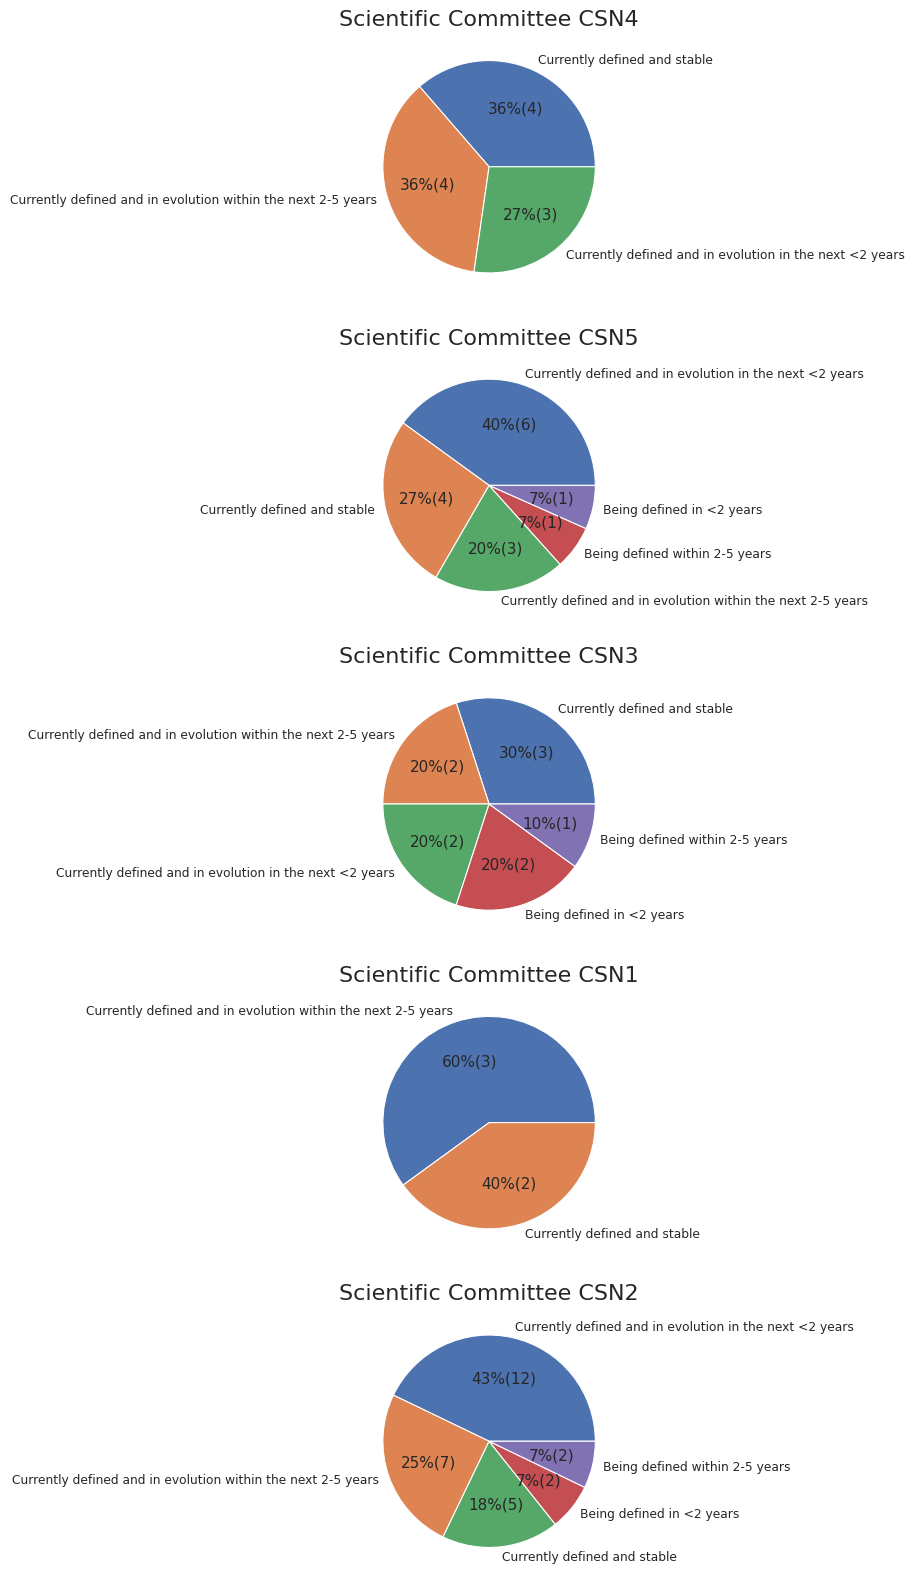

In [9]:

#data = df[(df["Scientific Committee"]=="CSN4") & (df["Computing model evolution"]=="Currently defined and stable")]["CPU - total amount (I)"]
#data = df[((df["Scientific Committee"]=="CSN1") | (df["Scientific Committee"]=="CSN2") | (df["Scientific Committee"]=="CSN3")) & (df["Computing model evolution"]=="Currently defined and stable")]["CPU - total amount (I)"]
#data = df[((df["Scientific Committee"]=="CSN1") | (df["Scientific Committee"]=="CSN2") | (df["Scientific Committee"]=="CSN3")) & (df["Computing model evolution"]=="Currently defined and stable")]["Storage - size (I)"]
def pie_by_who_what(who, what):
  fig, ax = plt.subplots(5,figsize=(4,20))
  CSN = pd.unique(df[who])
  for i, csn in enumerate(CSN):
    data = df[(df[who]==csn)][what]
    elements = len(data)
    pd.value_counts(data).plot(kind='pie', ax=ax[i], autopct=lambda x: '{:.0f}%({:.0f})'.format(x, x*elements/100), label="")
    ax[i].set_title(who+" "+csn)
  return ax
pie_by_who_what(who="Scientific Committee", what="Computing model evolution")
plt.show()

<div class="markdown-google-sans">

## pledge
</div>



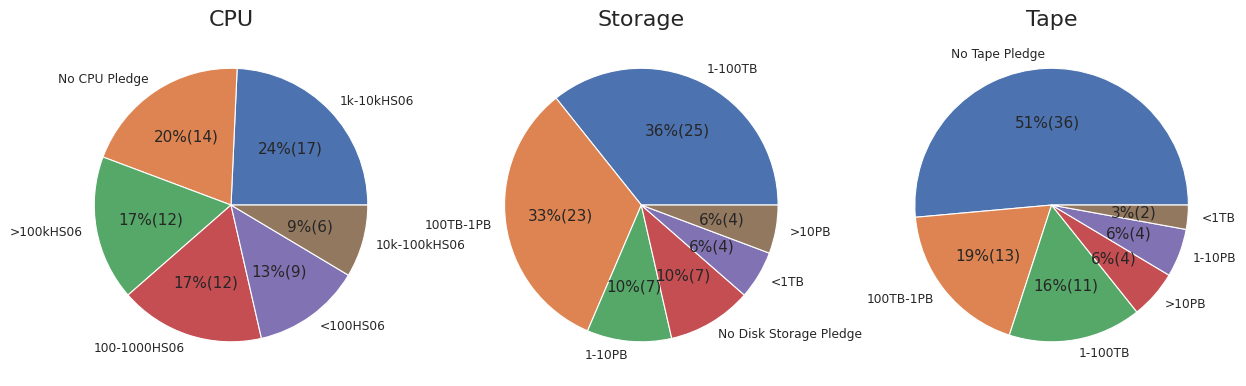

In [10]:
pledges = ["CPU - total amount (I)", "Storage - size (I)", "Tape - size (I)"]
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i, pledge in enumerate(pledges):
  data = df[pledge]
  elements = len(data)
  pd.value_counts(data).plot(kind='pie', ax=ax[i], autopct=lambda x: '{:.0f}%({:.0f})'.format(x, x*elements/100), label="")
  ax[i].set_title(pledge.split(' ')[0])

plt.show()

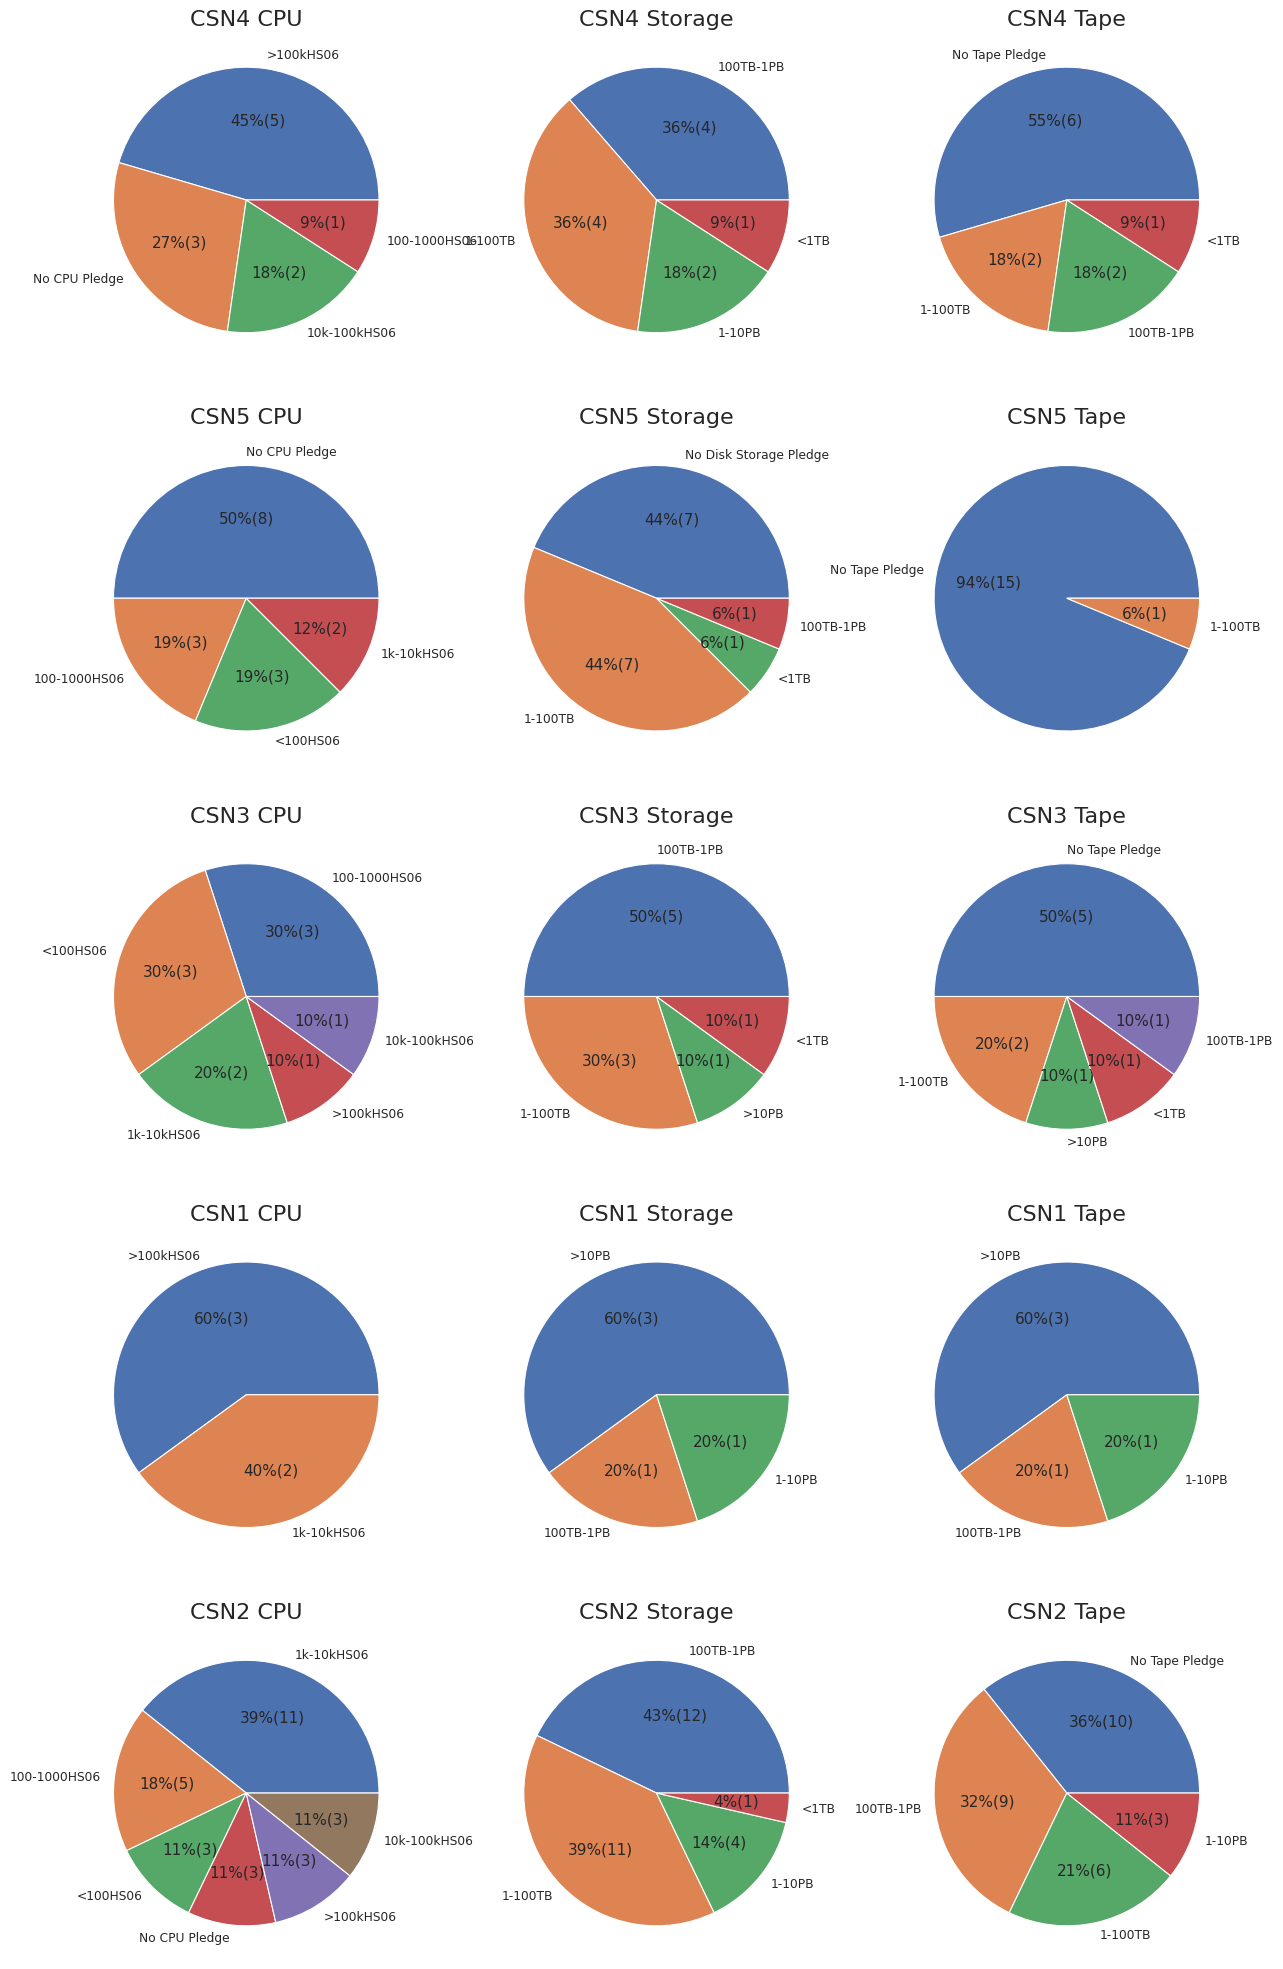

In [11]:
pledges = ["CPU - total amount (I)", "Storage - size (I)", "Tape - size (I)"]
fig, ax = plt.subplots(5,3,figsize=(15,25))
who = 'Scientific Committee'
for i, pledge in enumerate(pledges):
  for j, csn in enumerate(CSN):
    data = df[(df[who]==csn)][pledge]
    elements = len(data)
    pd.value_counts(data).plot(kind='pie', ax=ax[j,i], autopct=lambda x: '{:.0f}%({:.0f})'.format(x, x*elements/100), label="")
    ax[j,i].set_title(csn+" "+pledge.split(' ')[0])

plt.show()

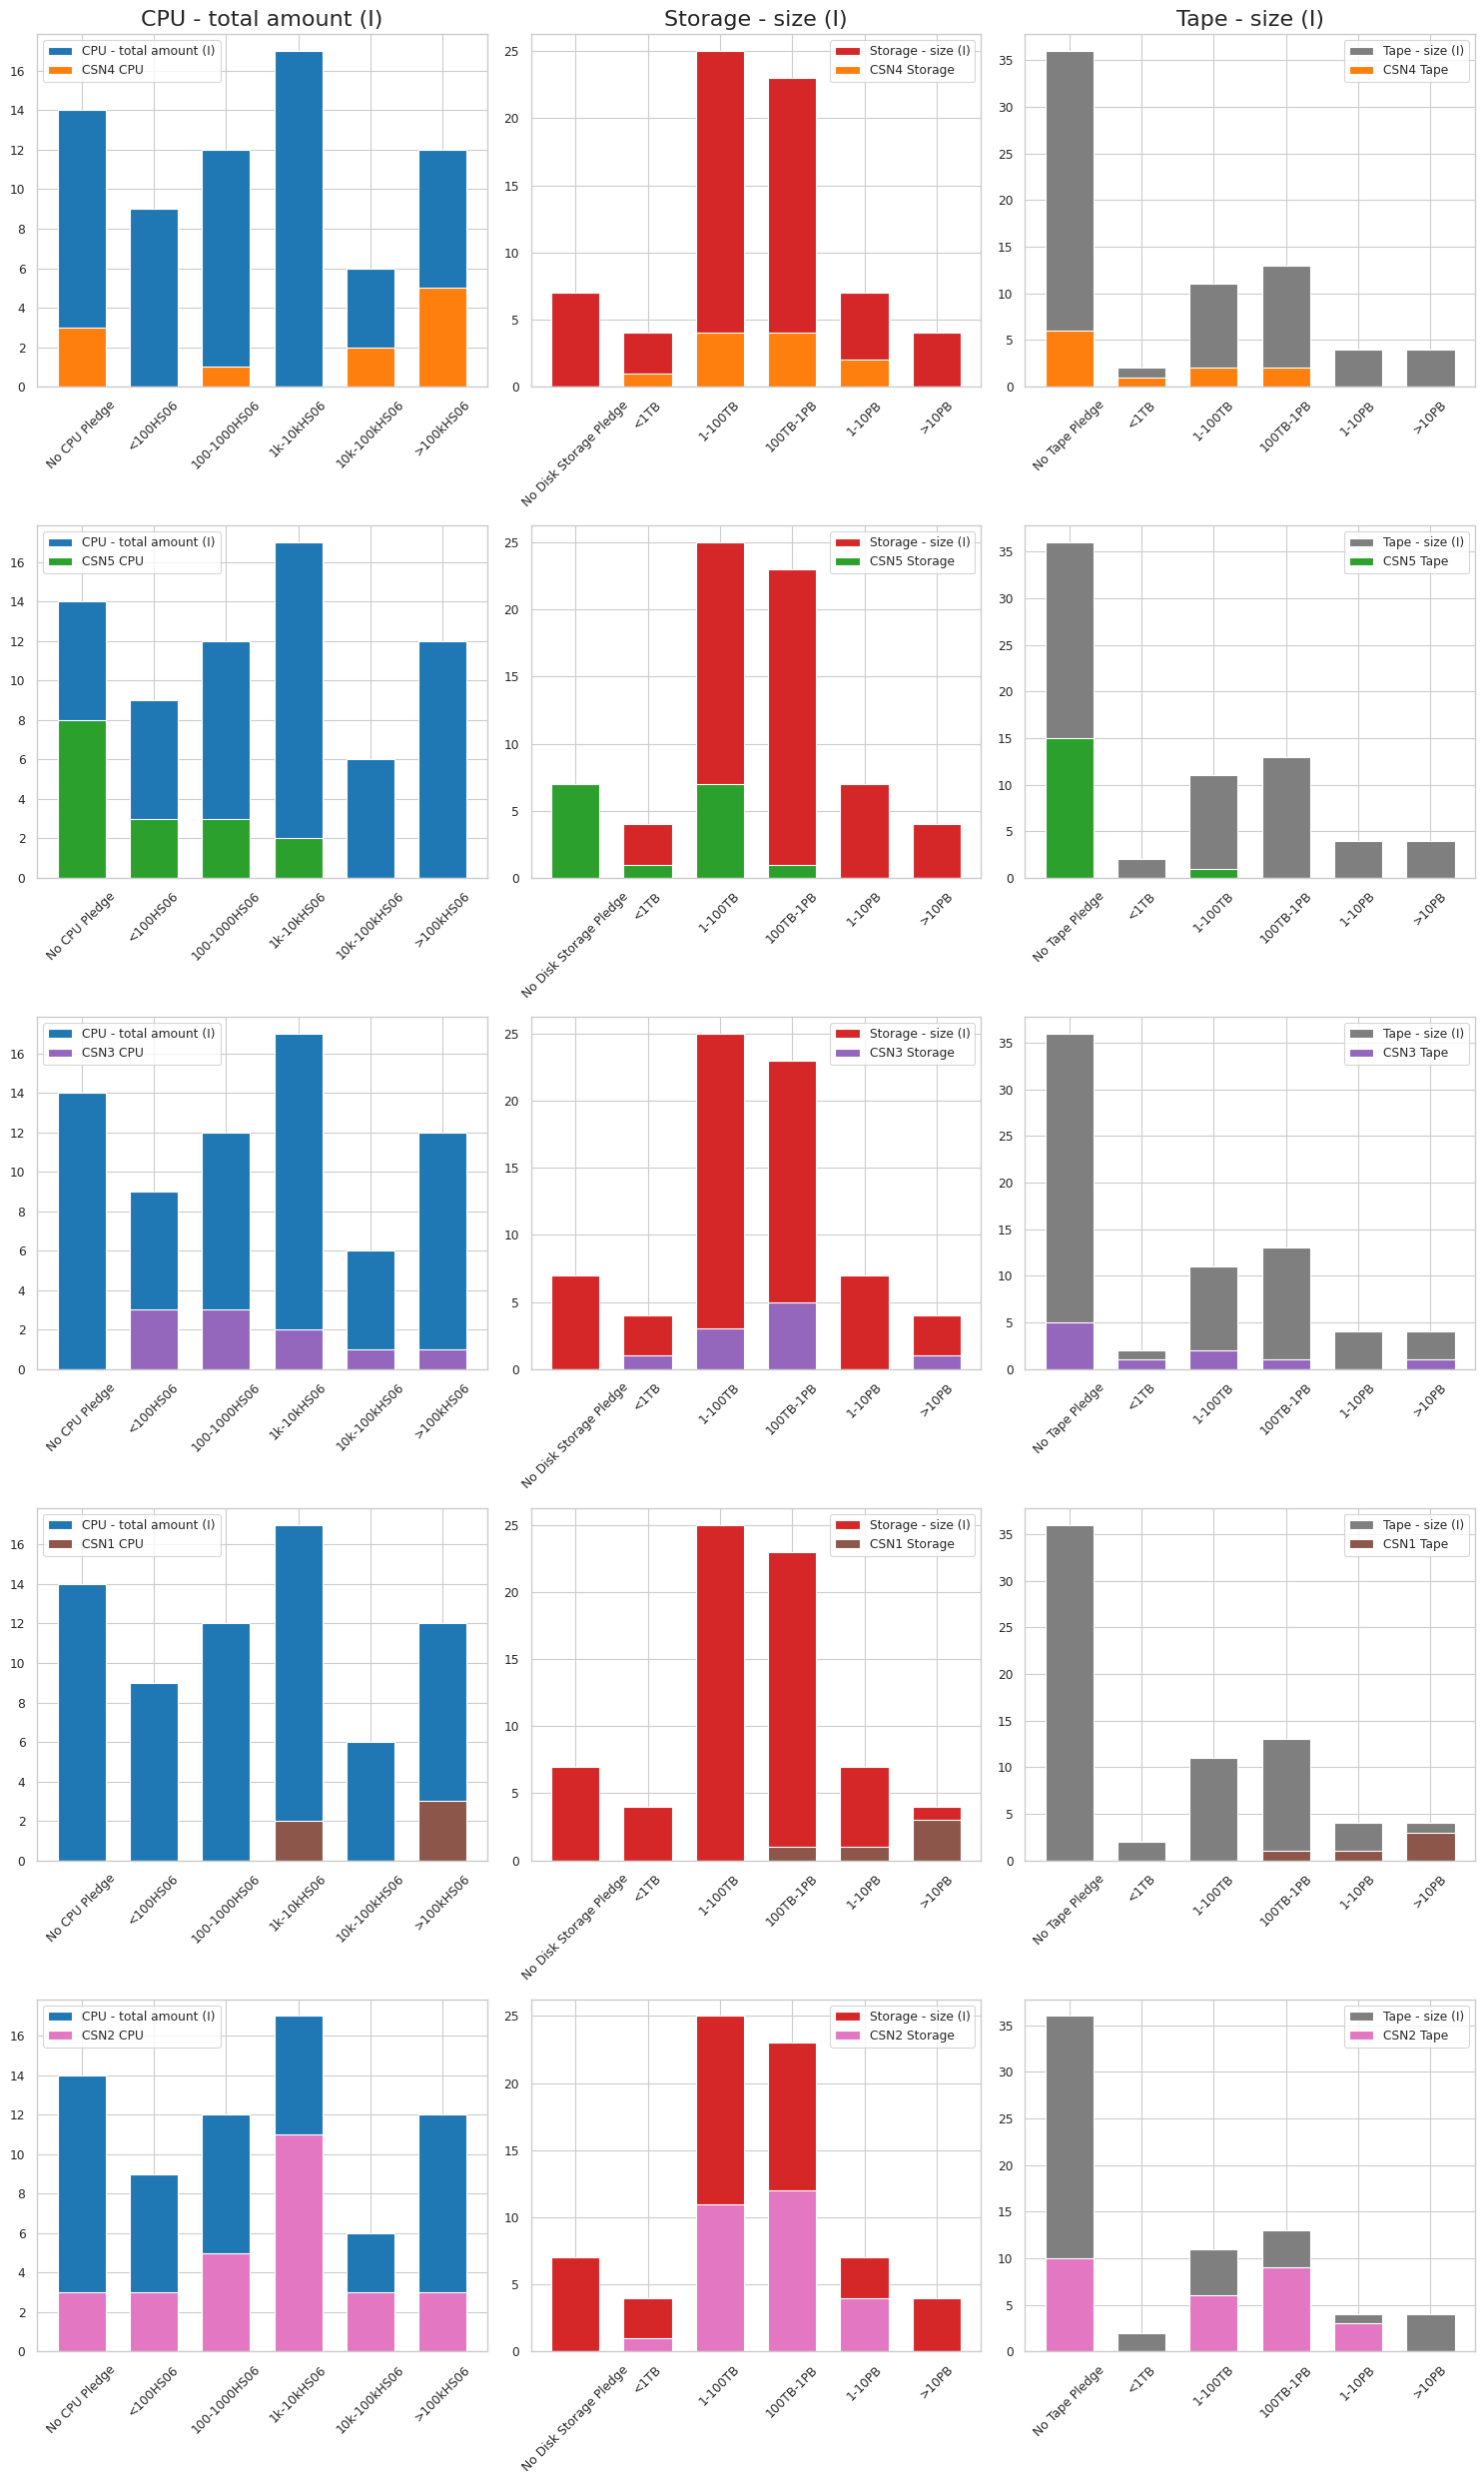

In [12]:
def ro_sort(a, pledge):
  r = [] # patch per sort dati CPU/Storage/Tape
  if pledge == "CPU - total amount (I)":
    r.append(a[1])
    r.append(a[4])
    r.append(a[2])
    r.append(a[3])
    r.append(a[5])
    r.append(a[0])
  elif pledge == "Storage - size (I)":
    r.append(a[2])
    r.append(a[3])
    r.append(a[4])
    r.append(a[0])
    r.append(a[1])
    r.append(a[5])
  elif pledge == "Tape - size (I)":
    r.append(a[0])
    r.append(a[5])
    r.append(a[1])
    r.append(a[2])
    r.append(a[4])
    r.append(a[3])
  else:
    print ("Error no change")
  return r

def hist_from_label(df, what, labels):
  data = []
  for i, label in enumerate(labels):
    data.append(len(df[df[what]==label]))
  return data


fig, ax = plt.subplots(5,3,figsize=(15,25))



for i, pledge in enumerate(pledges):
  labels = ro_sort(pd.unique(df[pledge]), pledge)
  data = hist_from_label(df, pledge, labels)
  x = np.linspace(0, len(data), len(data))

  for j, csn in enumerate(CSN):
    data2 = hist_from_label(df[df['Scientific Committee']==csn], pledge, labels)
    ax[j,i].bar(x, data, label=pledge, color=c[i])
    ax[j,i].bar(x, data2, label=csn+" "+pledge.split(' ')[0], color=c[3+j])
    ax[j,i].set_xticks(x, labels, rotation=45)
    ax[j,i].legend()

for bx, col in zip(ax[0], pledges):
    bx.set_title(col)
fig.tight_layout()
plt.show()

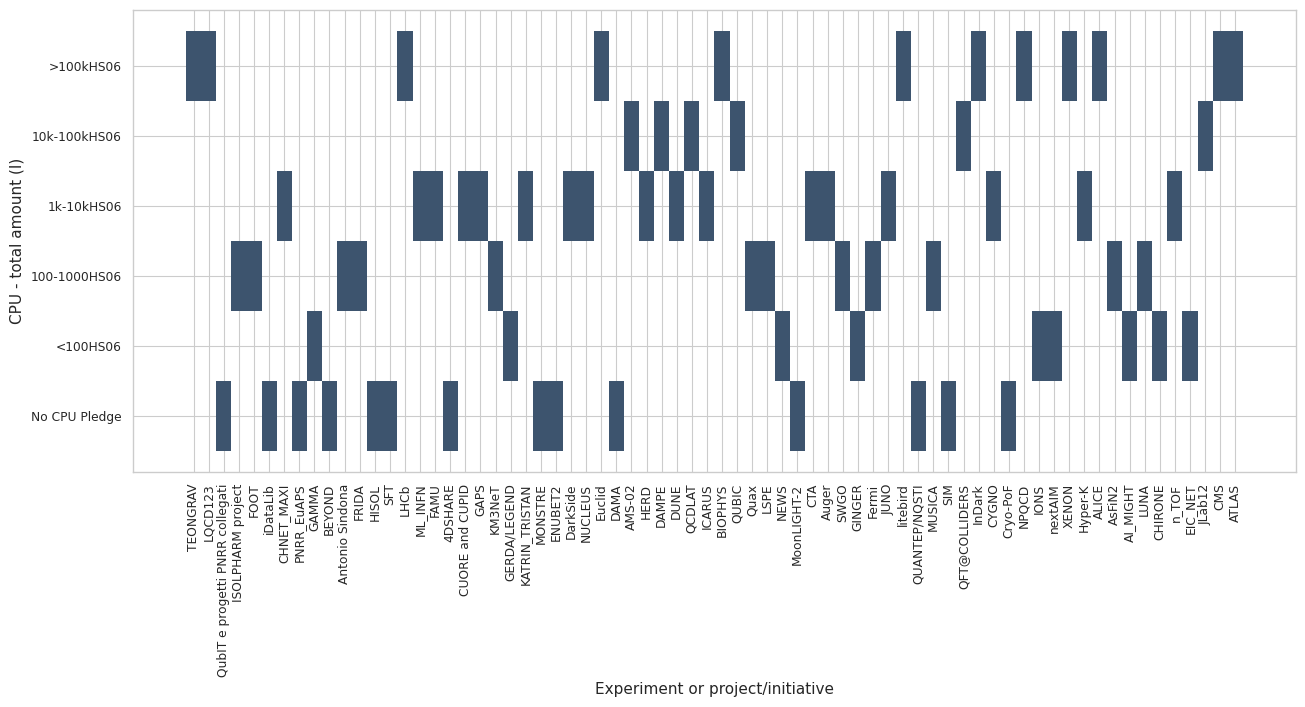

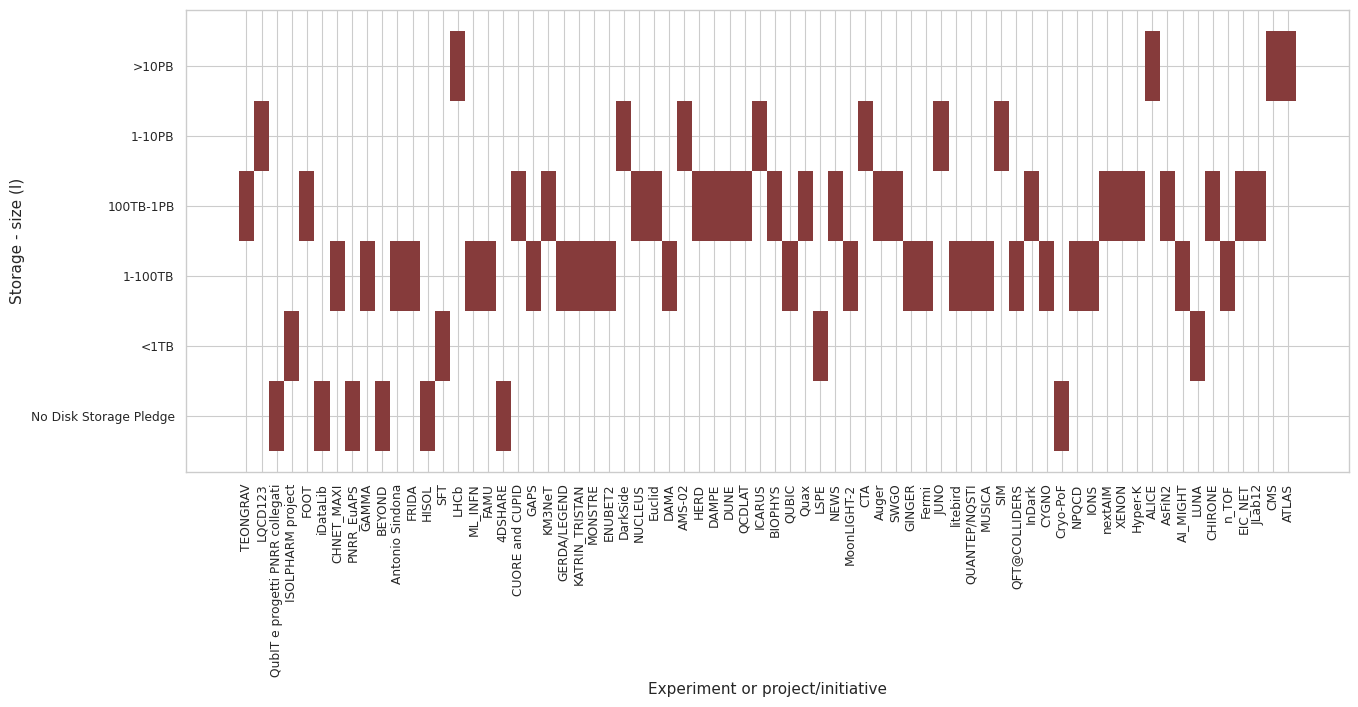

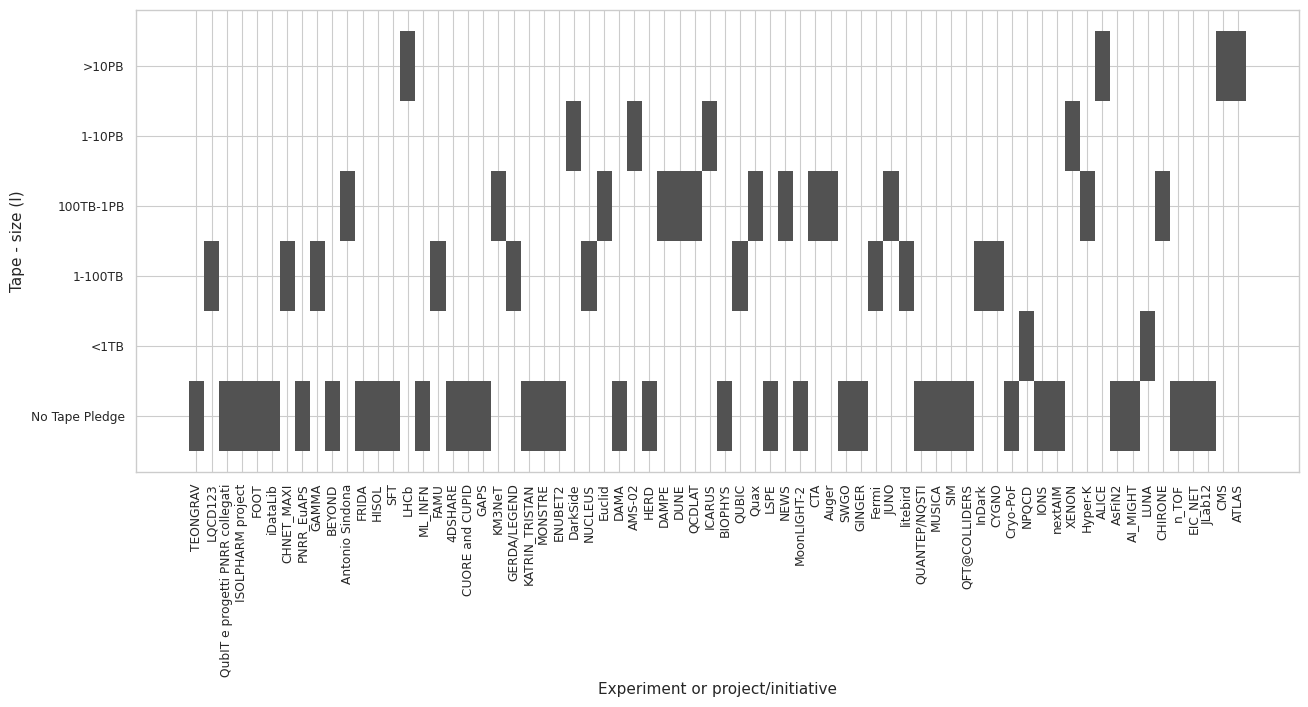

In [13]:
for i, pledge in enumerate(pledges):

  labels = ro_sort(pd.unique(df[pledge]), pledge)
  df[pledge] = pd.Categorical(df[pledge], labels[::-1])
  fig, ax = plt.subplots(figsize=(15,6))
  sns.histplot(df, x="Experiment or project/initiative", y=pledge, color=c[i])
  ax.tick_params(axis='x', rotation=90)
  plt.show()

In [19]:
df.columns


Index(['Timestamp', 'Email Address', 'Experiment or project/initiative',
       'Unnamed: 3', 'Computing model evolution', 'Real Data amount',
       'Real Data size', 'Data structure',
       'Metadata/calibrations/slow-control', 'Production sites', 'Workflow',
       'Data access', 'Details', 'Details, "arrows"', 'Details, "boxes"',
       'CPU - total amount (I)', 'CPU - HPC (I)', 'CPU - HTC',
       'CPU - interactive', 'CPU - batch system (I)', 'CPU - web based tools',
       'CPU - personal VMs', 'CPU - graphic access', 'CPU - services (I)',
       'CPU - temporary overpledge (I)', 'CPU - special environment (I)',
       'CPU - R&D', 'Storage - size (I)', 'Storage - experiment data (I)',
       'Storage - user data (I)', 'Storage - secondary data (I)',
       'Storage - executables and libraries', 'Storage - read-only',
       'Storage - POSIX', 'Storage - access (I)', 'Tape - size (I)',
       'Tape - access frequency (I)', 'Tape - inventory',
       'Tape - replicas and backups

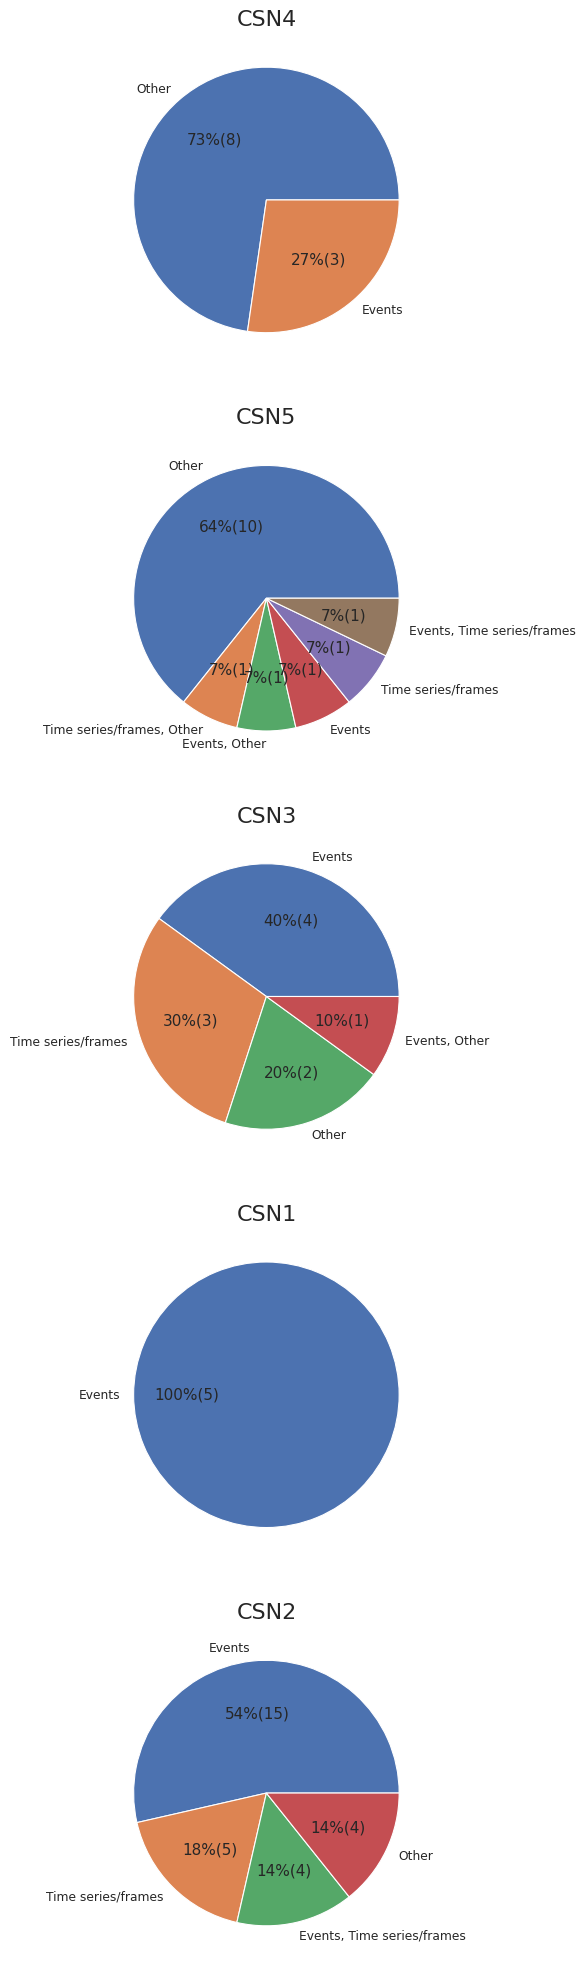

In [23]:
fig, ax = plt.subplots(5,figsize=(15,25))
who = 'Scientific Committee'
for j, csn in enumerate(CSN):
  data = df[(df[who]==csn)]['Data organization']
  elements = len(data)
  pd.value_counts(data).plot(kind='pie', ax=ax[j], autopct=lambda x: '{:.0f}%({:.0f})'.format(x, x*elements/100), label="")
  ax[j].set_title(csn)

plt.show()


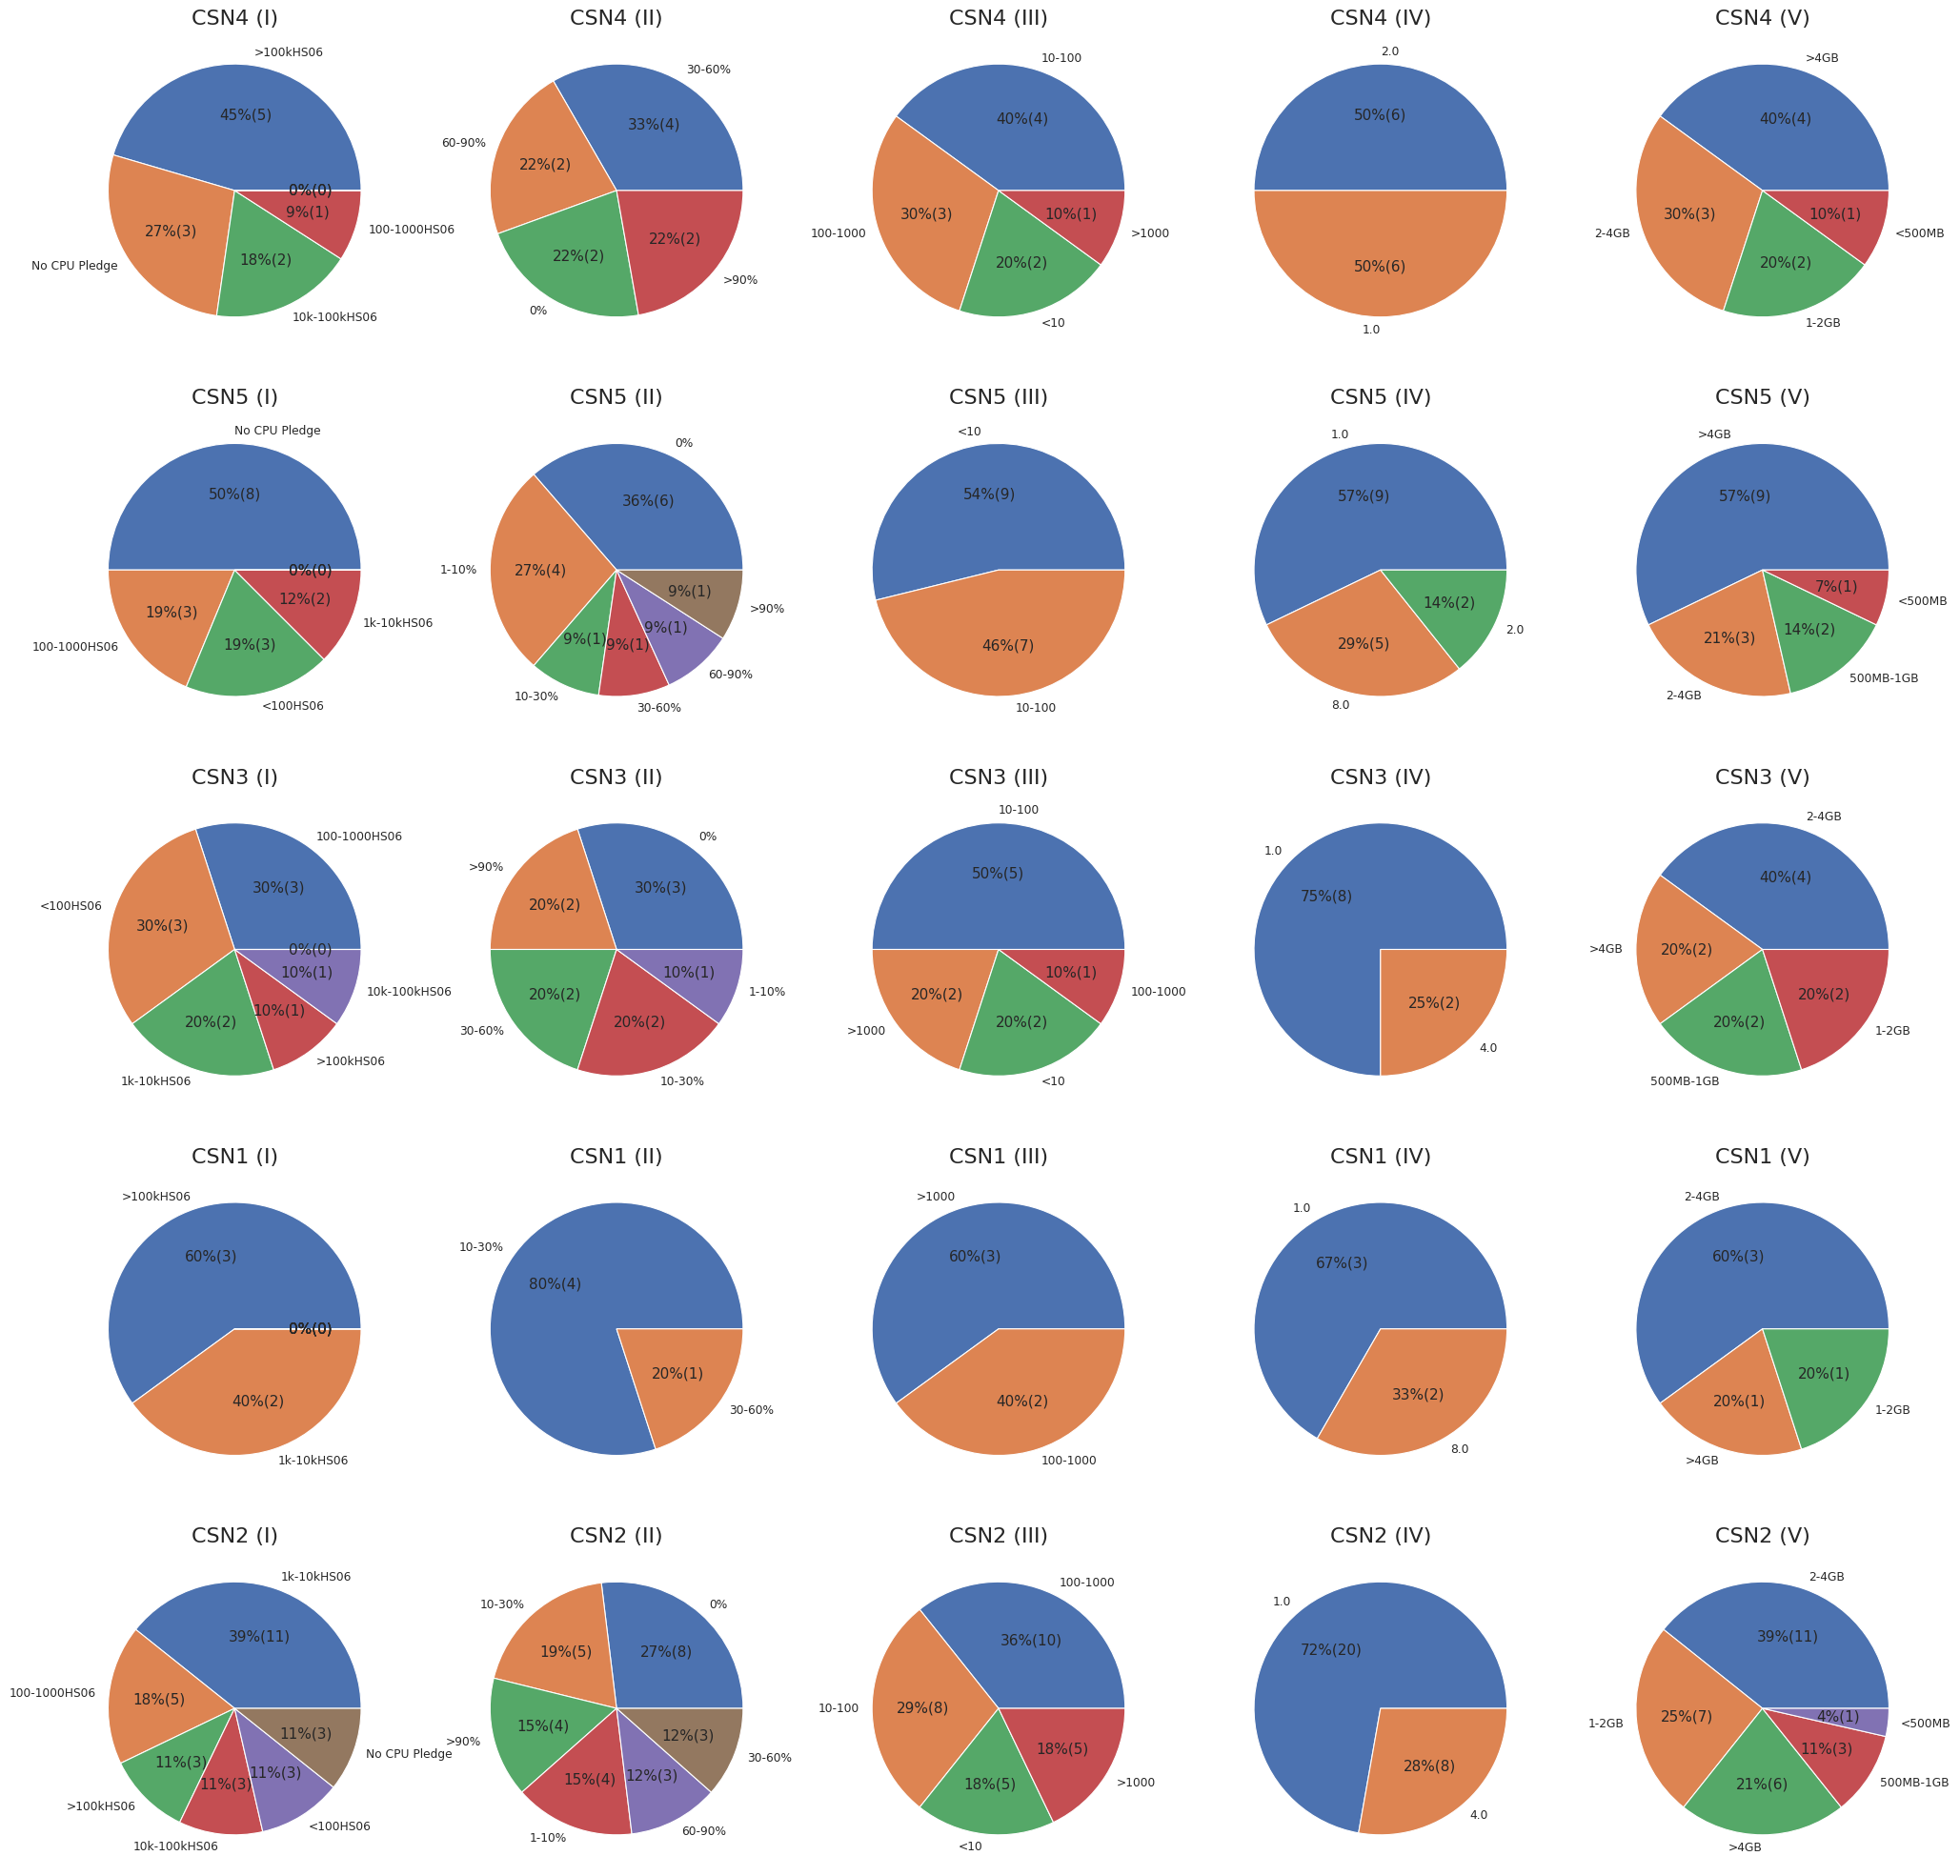

In [30]:
cpus = ["CPU - total amount (I)", "CPU - total amount (II)", "CPU - total amount (III)", "CPU - total amount (IV)", "CPU - total amount (V)"]
fig, ax = plt.subplots(5,5,figsize=(25,25))
who = 'Scientific Committee'
for i, cpu in enumerate(cpus):
  for j, csn in enumerate(CSN):
    data = df[(df[who]==csn)][cpu]
    elements = len(data)
    pd.value_counts(data).plot(kind='pie', ax=ax[j,i], autopct=lambda x: '{:.0f}%({:.0f})'.format(x, x*elements/100), label="")
    ax[j,i].set_title(csn+" "+cpu.split(' ')[-1])

plt.show()

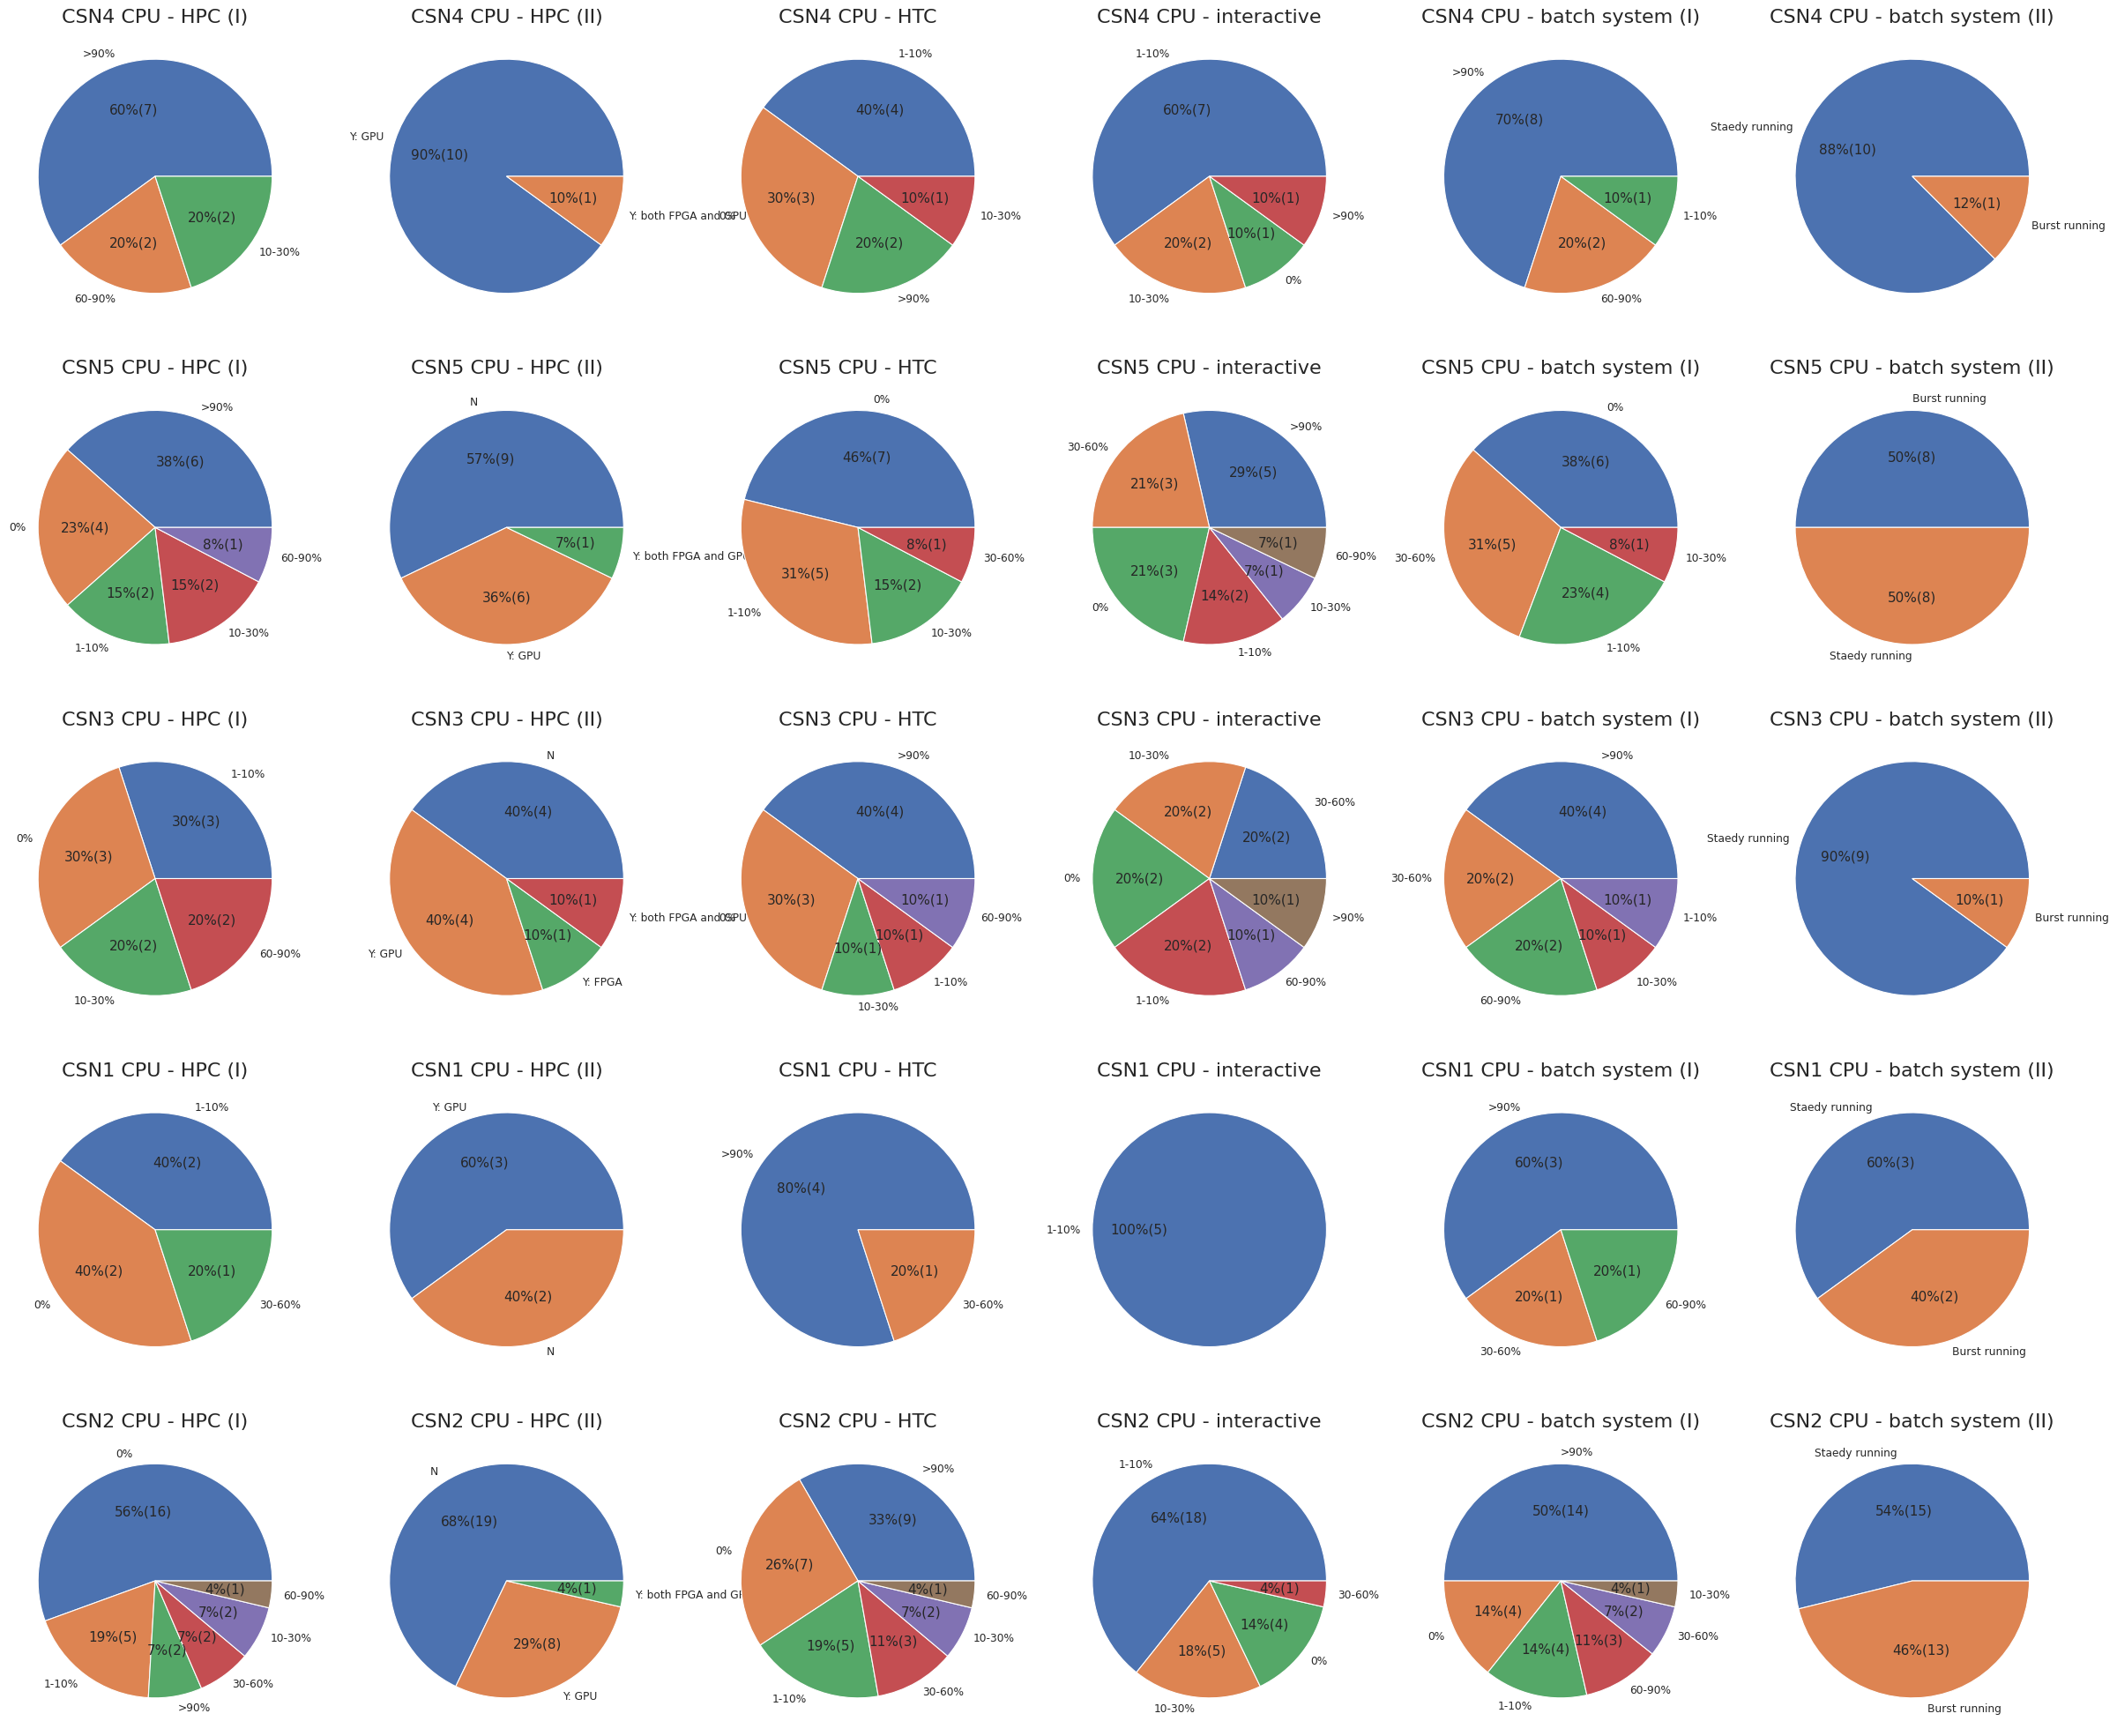

In [35]:
cpus = ["CPU - HPC (I)", "CPU - HPC (II)", "CPU - HTC", "CPU - interactive", "CPU - batch system (I)", "CPU - batch system (II)"]
fig, ax = plt.subplots(5,6,figsize=(30,25))
who = 'Scientific Committee'
for i, cpu in enumerate(cpus):
  for j, csn in enumerate(CSN):
    data = df[(df[who]==csn)][cpu]
    elements = len(data)
    pd.value_counts(data).plot(kind='pie', ax=ax[j,i], autopct=lambda x: '{:.0f}%({:.0f})'.format(x, x*elements/100), label="")
    ax[j,i].set_title(csn+" "+cpu)

plt.show()

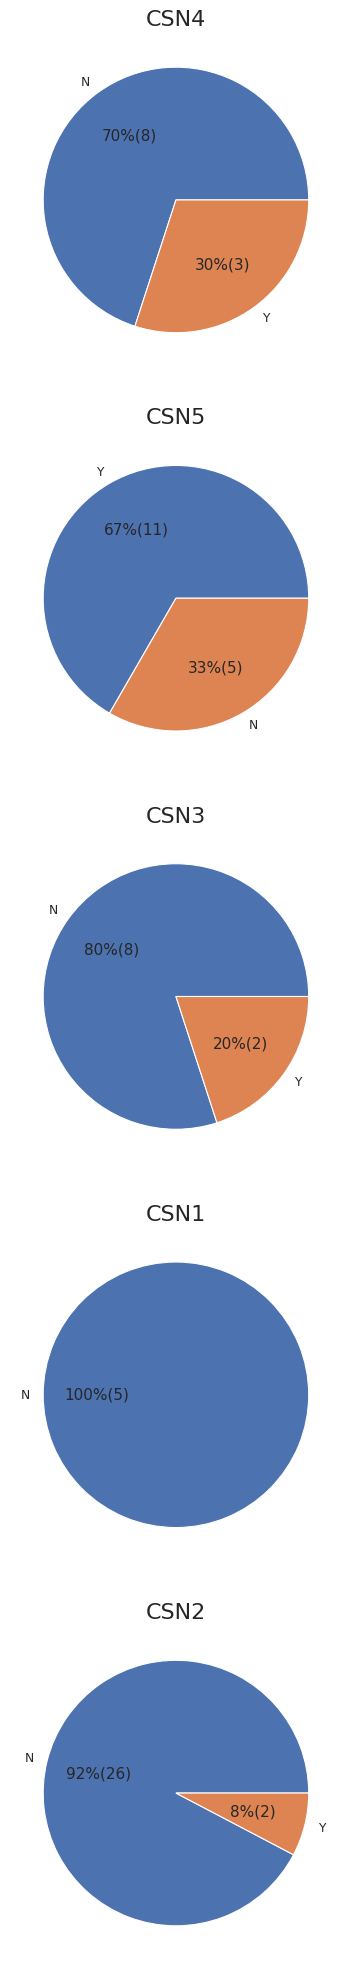

In [36]:
fig, ax = plt.subplots(5,figsize=(15,25))
who = 'Scientific Committee'
for j, csn in enumerate(CSN):
  data = df[(df[who]==csn)]['Software (I)']
  elements = len(data)
  pd.value_counts(data).plot(kind='pie', ax=ax[j], autopct=lambda x: '{:.0f}%({:.0f})'.format(x, x*elements/100), label="")
  ax[j].set_title(csn)

plt.show()